In [3]:
%matplotlib inline
from astropy.stats import sigma_clipped_stats
from photutils import CircularAperture, aperture_photometry, CircularAnnulus, DAOStarFinder
import astropy.io.fits as pf
import numpy as np
import seaborn as sns
sns.set()
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from matplotlib import pyplot as plt
import os
from scipy import stats
from scipy.optimize import curve_fit
from scipy import odr
import warnings
warnings.filterwarnings('ignore')

In [1]:
import astropy
astropy.__citation__

'@ARTICLE{2018AJ....156..123T,\n   author = {{The Astropy Collaboration} and {Price-Whelan}, A.~M. and {Sip{\\H o}cz}, B.~M. and \n\t{G{\\"u}nther}, H.~M. and {Lim}, P.~L. and {Crawford}, S.~M. and \n\t{Conseil}, S. and {Shupe}, D.~L. and {Craig}, M.~W. and {Dencheva}, N. and \n\t{Ginsburg}, A. and {VanderPlas}, J.~T. and {Bradley}, L.~D. and \n\t{P{\\\'e}rez-Su{\\\'a}rez}, D. and {de Val-Borro}, M. and {Paper Contributors}, (. and \n\t{Aldcroft}, T.~L. and {Cruz}, K.~L. and {Robitaille}, T.~P. and \n\t{Tollerud}, E.~J. and {Coordination Committee}, (. and {Ardelean}, C. and \n\t{Babej}, T. and {Bach}, Y.~P. and {Bachetti}, M. and {Bakanov}, A.~V. and \n\t{Bamford}, S.~P. and {Barentsen}, G. and {Barmby}, P. and {Baumbach}, A. and \n\t{Berry}, K.~L. and {Biscani}, F. and {Boquien}, M. and {Bostroem}, K.~A. and \n\t{Bouma}, L.~G. and {Brammer}, G.~B. and {Bray}, E.~M. and {Breytenbach}, H. and \n\t{Buddelmeijer}, H. and {Burke}, D.~J. and {Calderone}, G. and \n\t{Cano Rodr{\\\'{\\i}}gue

In [15]:
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project')
file = 'wcsM_0016.fits'
image = pf.open(file)
w = WCS(image[0].header)
sky = w.pixel_to_world(403,370)
print(sky)

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (82.16318658, 42.43770046)>


In [21]:
x = [82.150936,82.110034,82.158453,82.197666,82.182192,82.192476,82.113757,82.104471,82.095256,82.125836]
y = [42.449436,42.452321,42.478781,42.42245,42.480211,42.437444,42.478844,42.440872,42.420703,42.407897]
a = []
b = []
for i,j in zip(x,y):
    px, py = w.wcs_world2pix(i,j, 1)
    a.append(px)
    b.append(py)
    #print('{0} {1}'.format(px, py))
    
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project\2I Reduced')
file = 'reduceducdM_0016.fits'
image = pf.getdata(file)

a = np.array(a)
b = np.array(b)
a = a
b = b
print(a)
print(b)
mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'

positions = []
for i,j in zip(a,b):
    ID = []
    xref = i
    yref = j
    for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
        if -5<(k-xref)<5 and -5<(l-yref)<5:
            n = m-1
            ID.append(n)
            positions.append((k,l))
    print(sources[ID])

[456.48279859 630.32386073 425.85870196 256.73822809 325.14572785
 279.49119241 615.60899117 653.4841094  691.81933505 561.3374026 ]
[303.70315889 289.00858629 134.45243455 456.7318375  125.06715078
 370.69579183 136.18827253 355.15524497 471.65190858 543.95721311]
 id xcentroid ycentroid sharpness ... sky    peak      flux      mag    
--- --------- --------- --------- ... --- --------- --------- ----------
267 454.31999 300.47463 0.5570065 ...   0 171.13701 21.927674 -3.3524814
 id xcentroid ycentroid sharpness ... sky    peak      flux      mag   
--- --------- --------- --------- ... --- --------- --------- ---------
256 629.53038 286.10425  0.789143 ...   0 101.49539 10.171401 -2.518452
 id xcentroid ycentroid sharpness  ... sky    peak      flux     mag   
--- --------- --------- ---------- ... --- --------- --------- --------
106 425.36024 133.98549 0.57165338 ...   0 1275.4936 164.80713 -5.54244
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- -----

In [22]:
mags = []
magserrors = []
for i in positions:
    aperture = CircularAperture(i, r=3) 
    annulus_aperture = CircularAnnulus(i, r_in=12., r_out=15.)
    apers = [aperture, annulus_aperture]
    phot_table = aperture_photometry(image, apers)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'
    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
    bkg_total = bkg_mean * aperture.area
    net_star = phot_table['aperture_sum_0'] - bkg_total
    mags.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
    dfdx = -1.08574/phot_table['aperture_sum_0'][0]
    error = np.sqrt((dfdx**2)*(np.sqrt(phot_table['aperture_sum_0'][0]))**2)
    magserrors.append(error)

Beta: [  0.84600948 -20.9777086 ]
Beta Std Error: [0.04173341 0.54211357]
Beta Covariance: [[ 0.03172361 -0.40818798]
 [-0.40818798  5.35297603]]
Residual Variance: 0.05490163261009446
Inverse Condition #: 0.05204452568454697
Reason(s) for Halting:
  Sum of squares convergence


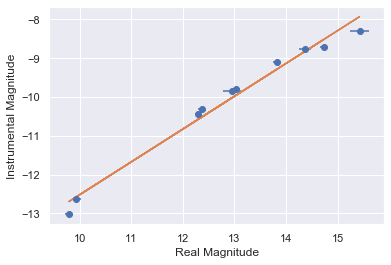

In [23]:
mags = np.array(mags)
Vmag = [15.758,16.402,13.119,15.872,13.806,10.272,12.923,14.323,11.868,14.98]
Vmag = np.array(Vmag)
Vmagerrors = [0.036,0.054,0.037,0.041,0.057,0.041,0.049,0.063,0.058,0.066]


rprime = [15.226,15.971,12.940,15.474,13.608,10.316,12.843,13.891,11.167,14.691]
rprimeerror = [0.13,0.15,0.026,0.068,0.046,0.033,0.027,0.041,0.033,0.071]

iprime = [14.84,15.842,12.726,15.178,13.39,10.326,12.771,13.502,10.349,14.299]
iprimeerror = [0.09,0.15,0.026,0.052,0.15,0.074,0.054,0.067,0.07,0.062,0.043]

Imag = []
Imagerror = []
for rp, ip, rperror, iperror in zip(rprime,iprime,rprimeerror,iprimeerror):
    r = rp +0.035*(rp-ip-0.21)
    rdrp = 1.035
    rdip = -0.035
    rerror = np.sqrt((rdrp**2)*rperror**2+(rdip**2)*iperror**2)
    
    i = ip + 0.041*(rp-ip-0.21)
    idrp = 0.041
    idip = 0.959
    ierror = np.sqrt((idrp**2)*rperror**2+(idip**2)*iperror**2)
    
   
    I = r-1.2444*(r-i)-0.382
    dr = -0.2444
    di = -1.2444
    Ierror = np.sqrt((dr**2)*(rerror**2)+(di**2)*(ierror**2))
    
    Imag.append(I)
    Imagerror.append(Ierror)
Imag = np.array(Imag)
Imagerror = np.array(Imagerror)



plt.errorbar(Imag,mags,xerr=Imagerror,yerr=magserrors,fmt='o')
plt.ylabel('Instrumental Magnitude')
plt.xlabel('Real Magnitude')

def func(p, x):
    m, c = p
    return m*x + c
mydata = odr.RealData(Imag, mags, sx = Imagerror, sy = None)
linear = odr.Model(func)
myodr = odr.ODR(mydata, linear,beta0 =[1, -23])
myoutput = myodr.run()
y = myoutput.beta[0]*Imag+myoutput.beta[1]
plt.plot(Imag,y)
myoutput.pprint()

In [24]:
xref = 402
yref = 371

mean, median, std = sigma_clipped_stats(image, sigma=5)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'
for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
    if -10<(k-xref)<10 and -10<(l-yref)<10:
        n = m-1
        ID.append(n)
print(sources[ID])

 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag    
--- --------- --------- ---------- ... --- --------- --------- -----------
494 69.779967 645.22753 0.79326549 ...   0 14.791244 1.6145089 -0.52010109
274 401.73333 369.90122 0.66121361 ...   0   56893.8 6404.4924  -9.5162118
283 393.48987 378.55575 0.33146587 ...   0 43.893805 1.4391053 -0.39523142


In [25]:
sourcemag = []
sourcemagerror = []
position = [(401.73333,369.90122)]
aperture = CircularAperture(position[0], r=3) 
annulus_aperture = CircularAnnulus(position[0], r_in=12., r_out=15.)
apers = [aperture, annulus_aperture]
phot_table = aperture_photometry(image, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
bkg_total = bkg_mean * aperture.area
net_star = phot_table['aperture_sum_0'] - bkg_total
sourcemag.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
sourcemagerror.append((-1.08574/phot_table['aperture_sum_0'][0])*np.sqrt(phot_table['aperture_sum_0'][0]))
print(sourcemag)

[-14.333293692460309]


In [26]:
dy = 1/myoutput.beta[0]
dc = -1/myoutput.beta[0]
dm = (myoutput.beta[1]-sourcemag[0])/(myoutput.beta[0])**2
error = np.sqrt((dy**2)*sourcemagerror[0]**2+(dc**2)*(myoutput.sd_beta[1])**2+(dm**2)*(myoutput.sd_beta[0])**2)
print((sourcemag[0]-myoutput.beta[1])/myoutput.beta[0],'+/-',error)

7.853830312940409 +/- 0.7488080390248498
